In [62]:
using Test

In [63]:
using Plots
using Printf

In [64]:
using Unitful

In [65]:
using DataFrames

In [66]:
using CSV

In [67]:
import Unitful:
    nm, μm, mm, cm, m, km,
    mg, g, kg,
    ps, ns, μs, ms, s, minute, hr, d, yr, Hz, kHz, MHz, GHz,
    eV,
    μJ, mJ, J,
	μW, mW, W

In [68]:
include("../src/LaserLab.jl")

Main.LaserLab

# Test setup

	struct Fov

Represent a field of view

#### Fields
- `d::Unitful.Length`  : diameter of Fov
- `z::Unitful.Length`  : thickness
- `a::Unitful.Area`    : area (computed)
- `v::Unitful.Volume`  : volume (computed)


In [69]:
fov = LaserLab.Fov(1.0mm,1.0mm)

Main.LaserLab.Fov(1.0 mm, 1.0 mm, 0.7853981633974483 mm², 0.7853981633974483 mm³)

In [70]:
@test fov.a ≈ π * (fov.d/2.)^2 
@test fov.v ≈ fov.a * fov.z

Test Passed

	struct CLaser <: Laser

Simple representation of a continous laser

### Fields
- `λ::typeof(1.0nm)`  : Laser wavelength
- `P::typeof(1.0mW)`  : Power

In [71]:
luv = LaserLab.CLaser(375.0nm, 1.0μW)

Main.LaserLab.CLaser(375.0 nm, 1.0 μW)

In [72]:
@test luv.P/μW ≈ 1 
@test luv.λ/nm ≈ 375.0

Test Passed

	Objective

Simple representation of a microscope objective

#### Fields
- `name::String`       : identifies the objective
- `mode::String`       : `d` if NA and diameter specified `f` if focal and NA specified 
- `NA::Float64`        : Numerical aperture
- `M::Float64`         : Magnification
- `f::typeof(1.0mm)`   : focal distance of the lens
- `d::typeof(1.0mm)`   : diameter of the lens


In [73]:
obj = LaserLab.Objective("Specify NA & M", 0.5, 40.0)
@printf("NA = %5.1f M = %5.1f ", obj.NA, obj.M)

NA =   0.5 M =  40.0 

In [74]:
@test obj.NA ≈ 0.5 
@test obj.M ≈ 40.0

Test Passed

In [75]:
obj2 = LaserLab.Objective("Specify f,d & M", 5.0mm, 5.0mm, 40.0)
@printf("NA = %5.1f M = %5.1f f = %5.1f d = %5.1f", obj2.NA, obj2.M, obj2.f/mm, obj2.d/mm)

NA =   0.5 M =  40.0 f =   5.0 d =   5.0

In [76]:
@test obj2.NA ≈ 0.5 
@test obj2.M ≈ 40.0
@test obj2.f/mm ≈ 5.0
@test obj2.d/mm ≈ 5.0

Test Passed

In [77]:
dspot(λ::Real, NA::Real) = 1.83*λ/(2*NA)

dspot (generic function with 1 method)

In [78]:
dspot(360.0, 0.5) 

658.8000000000001

In [79]:
dspot(500.0, 0.5) 

915.0

In [80]:
@test LaserLab.lmu_40x_nuv_transmission(0.500μm) ==LaserLab.lmu_40x_nuv_transmission(500nm)

Test Passed

In [81]:
LaserLab.lmu_40x_nuv_transmission(500nm)

0.772

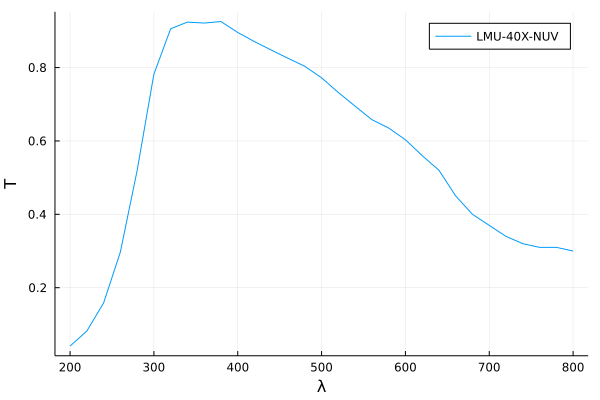

In [82]:
wl=200.0:20:800.0
plot(wl, LaserLab.lmu_40x_nuv_transmission.(wl*nm), label="LMU-40X-NUV")
xlabel!("λ")
ylabel!("T")

	struct PulsedLaser

Simple representation of a pulsed laser

#### Fields
- `λ::Unitful.Length`  : Laser wavelength
- `Pk::Unitful.Power`  : peak Power
- `P::Unitful.Power`  : average power
- `f::Unitful.Frequency`  : laser frequency
- `w::Unitful.Time` : pulse width 

In [83]:
epl375 = LaserLab.PulsedLaser(375.0nm, 140.0mW, 1.0MHz, 65.0ps)

Main.LaserLab.PulsedLaser(375.0 nm, 140.0 mW, 1.0 MHz, 0.0091 mW, 65.0 ps)

In [84]:
lmu_40x_nuv = LaserLab.Objective("LMU-40X-NUV", 5.3mm, 5.1mm, 40.0)

Main.LaserLab.Objective("LMU-40X-NUV", 0.48113207547169806, 40.0, 5.3 mm, 5.1 mm)

In [85]:
@test lmu_40x_nuv.NA  ≈ lmu_40x_nuv.d / (2.0*lmu_40x_nuv.f)

Test Passed

In [86]:
@test epl375.P == epl375.Pk * epl375.w * epl375.f

Test Passed


	photon_energy(λ::Unitful.Length)

Given wavelength of photon return its energy.
#### Fields

- `λ::Unitful.Length`  : Photon wavelength


In [87]:
LaserLab.photon_energy(500.0nm)

2.4796839686640055 eV

In [88]:
function hnu_eV(lambda_nm)
    return 1240.0 * (1.0/lambda_nm)
end


hnu_eV (generic function with 1 method)

In [89]:
@test isapprox(LaserLab.photon_energy(500.0nm)/eV, hnu_eV(500.0), rtol=0.01)

Test Passed

	delivered_energy(laser::Laser, t::Unitful.Time)

Delivered energy of a laser in a given time.
#### Fields

- `laser::Laser`     : Laser
- `t::Unitful.Time`  : Time in which target is illuminated


In [90]:
uconvert(J, LaserLab.delivered_energy(luv, 1*s)) ≈ 1.0μJ

true

	n_photons(laser::Laser)

Rate of photons (number of photons per unit time) produced by a laser
#### Fields

- `laser::Laser`     : Laser
- `t::Unitful.Time`  : Time in which target is illuminated


In [91]:
LaserLab.n_photons(luv)

1.887793712828516e12 Hz

    n_photons(λ::Unitful.Length, p::Unitful.Power)

Rate of photons (number of photons per unit time) corresponding to a wavelength
λ and a power P

#### Fields

- `λ::Unitful.Length` : photon wavelength
- `p::Unitful.Power`  : Power

In [92]:
LaserLab.n_photons(luv) ≈ LaserLab.n_photons(375.0nm, 1.0μW)

true

	n_photons_int(laser::Laser, t::Unitful.Time)

Integrated number of photons in a given time emitted by a laser

#### Fields

- `laser::Laser`    : Laser
- `t::Unitful.Time` : time of measurement

In [93]:
LaserLab.n_photons_int(luv, 1.0s) ≈ LaserLab.n_photons(luv)/Hz

true

    photon_density(λ::Unitful.Length, p::Unitful.Power, a::Unitful.Area)

number of photons per unit time per unit area

#### Fields

- `λ::Unitful.Length` : photon wavelength
- `p::Unitful.Power`  : Power
- `a::Unitful.Area`   : Area

In [94]:
LaserLab.photon_density(375.0nm, 1.0μW, fov.a)

2.4036136074756826e12 Hz mm⁻²

	photon_density(l::Laser, fov::Fov)

number of photons per unit time per unit area, in a Fov illuminated by a laser

#### Fields

- `laser::Laser` : Laser
- `fov::Fov`     : Field of view


In [95]:
@test LaserLab.photon_density(375.0nm, 1.0μW, fov.a) ≈ LaserLab.photon_density(luv, fov)

Test Passed